In [ ]:
!pip install git+https://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]

In [ ]:
import numpy as np
import os

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.configs import QuantizationConfig
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec

import matplotlib.pyplot as plt

print('Imported successfully!')

In [ ]:
# Unzipping files
!unzip ./dataset.zip
!rm -r ./dataset.zip

In [ ]:
# Load data
data = ImageClassifierDataLoader.from_folder(os.path.join(os.getcwd(), 'dataset'))
train_data, test_data = data.split(0.9)

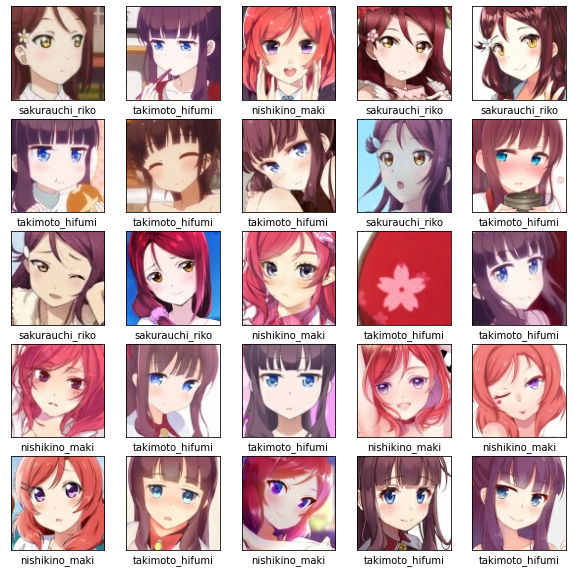

In [6]:
# Data Exploration
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.dataset.take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [ ]:
# Customize the TensorFlow model
model = image_classifier.create(train_data)

In [ ]:
model.summary()

In [ ]:
# Model Evaluation
loss, accuracy = model.evaluate(test_data)
model.export(export_dir = os.getcwd())

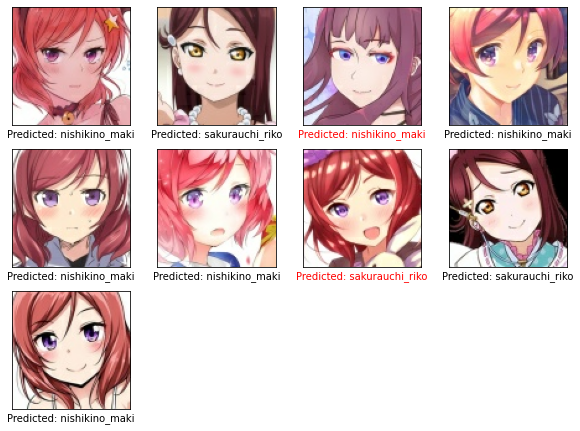

In [16]:
# A helper function that returns 'red'/'black' depending on if its two input parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 9 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test" dataset,
# Let's simply highlight it in red color.
plt.figure(figsize=(10, 10))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(9)):
  ax = plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()